## Cleaning Dataset: User Behaviour dataset

### 1. Handling Duplicates
Duplicates can bias frequency-based insights 

In [2]:
import pandas as pd
import numpy as np
df = pd.read_excel("C:/Users/adith/spotify_analytics/data/raw/Spotify_data.xlsx")
df.duplicated().sum()
df.head()


,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free (ad-supported),Yes,Family Plan-Rs 179/month,Podcast,Melody,Night,Sadness or melancholy,leisure time,Playlists,3,Daily,Comedy,Interview,Both,Both,Ok
1,12-20,Male,More than 2 years,Computer or laptop,Free (ad-supported),Yes,Individual Plan- Rs 119/ month,Podcast,Rap,Afternoon,Social gatherings or parties,Workout session,Playlists,2,Several times a week,Comedy,Interview,Both,NaN,Satisfied
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free (ad-supported),Yes,Student Plan-Rs 59/month,Podcast,Pop,Night,Relaxation and stress relief,"Study Hours, While Traveling",Playlists,4,Once a week,Sports,Interview,NaN,Both,Satisfied
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free (ad-supported),No,NaN,Music,Melody,Night,"Relaxation and stress relief, Social gathering...","Office hours, Workout session, leisure time","recommendations, Playlists",4,Never,NaN,NaN,NaN,NaN,Ok
4,20-35,Female,1 year to 2 years,Smartphone,Free (ad-supported),No,NaN,Music,Melody,Night,Relaxation and stress relief,leisure time,"recommendations, Playlists",4,Rarely,Lifestyle and Health,Story telling,Well known individuals,Both,Ok


In [3]:
df = df.drop_duplicates()

In [4]:
df.duplicated().sum()
# before duplicate drop = (520, 20)
# after duplicate drop = (519, 20)

np.int64(0)

### Inspect and Handle Missing Values

here missingness can be meaningful or it could be accidental and we need to handle that and accordingly.

Strategy:
1. Logical nulls keep as it is or handle it in such a way that it make it more valuable for interpretation.

2. Accidental nulls can be imputed with mean, median, mode, or a constant value, depending on the data type.

3. High missingness columns (>50% nulls): Consider dropping if not analytically relevant.

In [5]:
df.isnull().sum()


Age                              0
Gender                           0
spotify_usage_period             0
spotify_listening_device         0
spotify_subscription_plan        0
premium_sub_willingness          0
preffered_premium_plan         207
preferred_listening_content      0
fav_music_genre                  0
music_time_slot                  0
music_Influencial_mood           0
music_lis_frequency              0
music_expl_method                0
music_recc_rating                0
pod_lis_frequency                0
fav_pod_genre                  147
preffered_pod_format           139
pod_host_preference            140
preffered_pod_duration         128
pod_variety_satisfaction         0
dtype: int64

| Column | Missing Count | % Missing | Possible Meaning | Cleaning Decision | Justification |
|--------|---------------|-----------|------------------|-------------------|---------------|
| `preferred_premium_plan` | 207 | ~39.8% | Missing for users who said No in `premium_sub_willingness` | ✅ Keep as NaN | This is logical missingness, not an error. Filling it with "Unknown" or "None" will distort true intent — because "No" already encodes that. |
| `fav_pod_genre` | 147 | ~28.3% | Users who don't listen to podcasts or listen rarely | ⚙️ Impute with `"No Podcasts"` | This conveys business meaning clearly instead of a generic "Unknown". |
| `preferred_pod_format` | 139 | ~26.7% | Similar reason — they don't engage with podcasts enough to have a preferred format | ⚙️ Impute with `"No Podcasts"` | Keeps categorical consistency and clarity in future grouping. |
| `pod_host_preference` | 140 | ~26.9% | No active podcast listeners → no host preference | ⚙️ Impute with `"No Podcasts"` | This field is dependent on podcast engagement, so this mapping maintains relationship. |
| `preferred_pod_duration` | 128 | ~24.6% | Same pattern — duration preference only exists for podcast listeners | ⚙️ Impute with `"No Podcasts"` | Maintains consistency with other podcast-related fields and preserves business logic. |

Assuming that the null values of preffered_premium_plan are logical needs to make sure that the missing values are all due to marked NO in premium_sub_willingness.


In [6]:
df['premium_sub_willingness'].value_counts()

premium_sub_willingness
No     333
Yes    186
Name: count, dtype: int64

In [7]:
df['preffered_premium_plan'].isnull().sum()


np.int64(207)

Interpretation:
1. Not all "No" entries are missing a preferred plan.
2. there might be some data entry quirks: some users who said "No" still have a value in preffered_premium_plan.
3. Conversly some "Yes" users might be missing the plan (less likely but worth inspecting.)


In [8]:
pd.crosstab(df['premium_sub_willingness'], df['preffered_premium_plan'])

preffered_premium_plan,Duo plan- Rs 149/month,Family Plan-Rs 179/month,Individual Plan- Rs 119/ month,Student Plan-Rs 59/month
premium_sub_willingness,,,,
No,32,13,26,60
Yes,52,26,69,34


#### Step-by-step validation
| Category | Total (from `value_counts`) | With `preferred_premium_plan` | Missing `preferred_premium_plan` |
|----------|----------------------------|-------------------------------|----------------------------------|
| No       | 333                        | 131                           | 333 - 131 = 202                  |
| Yes      | 186                        | 181                           | 186 - 181 = 5                    |
| **Total** | **519**                    | **312**                       | **202 + 5 = 207**                |

Interpretation

So among the 207 missing preferred_premium_plan values:

202 belong to people who said “No” (not willing to subscribe to premium).

5 belong to people who said “Yes” (willing to subscribe, but didn’t specify which plan).

That’s coherent and consistent with our logic and the data’s internal distribution — meaning our mapping between the two features (premium_sub_willingness → preferred_premium_plan) is valid and we’re not breaking any relational consistency.

#### Handling the missing values for premium_plan

In [9]:
# Fill only missing preferred_premium_plan where premiun_sub_willingness = No
mask_no_missing = (df['premium_sub_willingness']== 'No') & (df['preffered_premium_plan'].isnull())
df.loc[mask_no_missing, 'preffered_premium_plan'] = 'None'

#Fill the small number of Yes rows with missing plan as Unknown
mask_yes_missing = (df['premium_sub_willingness']== 'Yes') & (df['preffered_premium_plan'].isnull())
df.loc[mask_yes_missing, 'preffered_premium_plan'] = 'Unknown'

In [10]:
df['preffered_premium_plan'].value_counts()

preffered_premium_plan
None                              202
Individual Plan- Rs 119/ month     95
Student Plan-Rs 59/month           94
Duo plan- Rs 149/month             84
Family Plan-Rs 179/month           39
Unknown                             5
Name: count, dtype: int64

In [11]:
def standardize_preferred_plan(value):
    if pd.isna(value):
        return value  # keep NaN or already-filled values

    value = value.strip()

    if "Duo" in value:
        return "Duo plan"
    elif "Family" in value:
        return "Family plan"
    elif "Individual" in value:
        return "Individual plan"
    elif "Student" in value:
        return "Student plan"
    elif value == "None":
        return "None"
    elif value == "Unknown":
        return "Unknown"
    else:
        return value
df['preffered_premium_plan'] = df['preffered_premium_plan'].apply(standardize_preferred_plan)

In [12]:
df['preffered_premium_plan'].isnull().sum()          # should be 0 after fills
df['preffered_premium_plan'].value_counts(dropna=False)
pd.crosstab(df['premium_sub_willingness'], df['preffered_premium_plan'], dropna=False)

preffered_premium_plan,Duo plan,Family plan,Individual plan,None,Student plan,Unknown
premium_sub_willingness,,,,,,
No,32,13,26,202,60,0
Yes,52,26,69,0,34,5


In [13]:
df['premium_sub_willingness_binary'] = df['premium_sub_willingness'].map({'Yes': 1, 'No': 0})
pd.crosstab(df['premium_sub_willingness_binary'], df['preffered_premium_plan'], dropna=False)

preffered_premium_plan,Duo plan,Family plan,Individual plan,None,Student plan,Unknown
premium_sub_willingness_binary,,,,,,
0,32,13,26,202,60,0
1,52,26,69,0,34,5


In [14]:
cols_to_check = [
    'fav_pod_genre',
    'preffered_pod_format',
    'pod_host_preference',
    'preffered_pod_duration'
 ]
for col in cols_to_check:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(dropna=False))



Column: fav_pod_genre
fav_pod_genre
NaN                                                 147
Comedy                                              107
Lifestyle and Health                                102
Health and Fitness                                   78
Sports                                               51
Food and cooking                                     20
Business                                              1
Everything                                            1
Informative stuff                                     1
Dance and Relevant cases                              1
Technology                                            1
General knowledge                                     1
Spiritual and devotional                              1
Finance related and current affairs                   1
Murder Mystery                                        1
Political, informative, topics that interests me      1
Novels                                                1
Self help  

In [15]:
podcast_cols = [
    'fav_pod_genre',
    'preffered_pod_format',
    'pod_host_preference',
    'preffered_pod_duration'    
]
for col in podcast_cols:
    df[col] = df[col].fillna('No Podcast Usage')

In [16]:
cols_to_verify = [
    'fav_pod_genre',
    'preffered_pod_format',
    'pod_host_preference',
    'preffered_pod_duration'
 ]
for col in cols_to_verify:
   print(f"Null values in {col}: {df[col].isnull().sum()}")


Null values in fav_pod_genre: 0
Null values in preffered_pod_format: 0
Null values in pod_host_preference: 0
Null values in preffered_pod_duration: 0


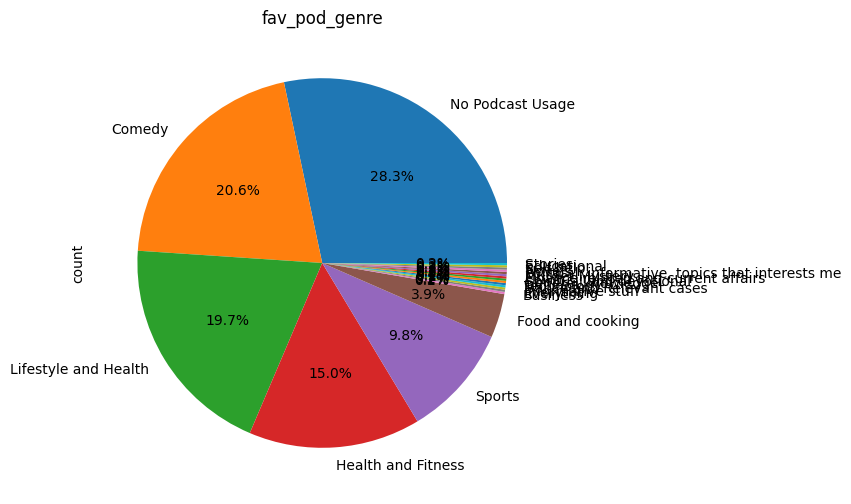

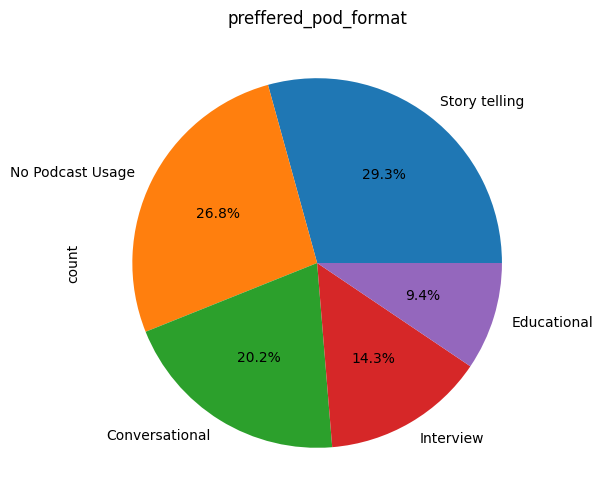

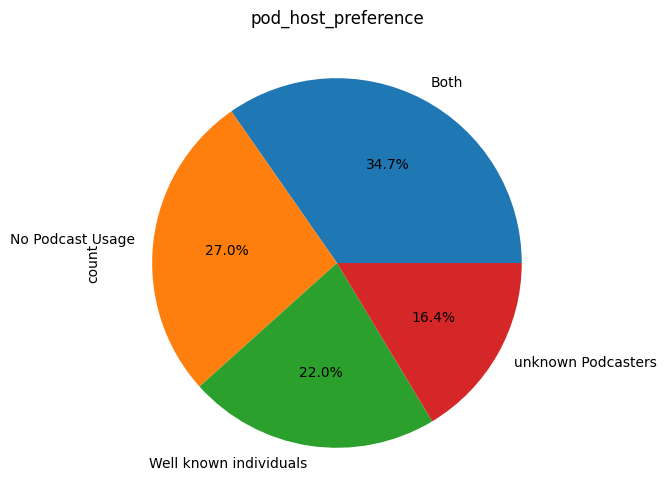

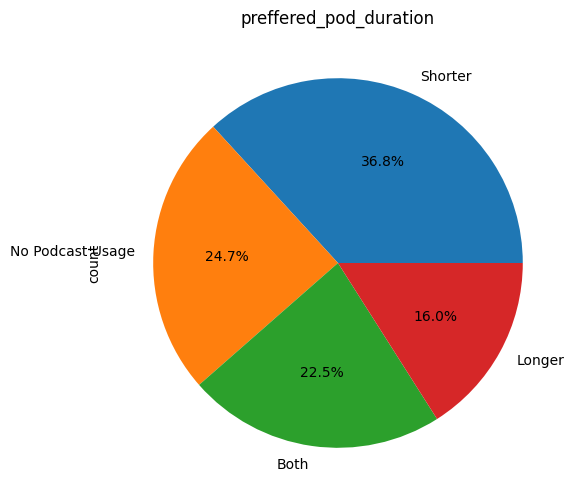

In [17]:
import sys
import os

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from visualization import plot_categorical_distribution
col_distribution = [
    'fav_pod_genre',
    'preffered_pod_format',
    'pod_host_preference',
    'preffered_pod_duration'
]
for col in col_distribution:
    plot_categorical_distribution(df[col], chart_type='pie')

In [18]:
top_genre = ['Comedy', 'Lifestyle and Health', 'Health and Fitness', 'Sports', 'No Podcast Usage','Food and cooking']
df['fav_pod_genre'] = df['fav_pod_genre'].apply(
    lambda x: x if x in top_genre else 'Other'
)

In [19]:
df['fav_pod_genre'].value_counts()


fav_pod_genre
No Podcast Usage        147
Comedy                  107
Lifestyle and Health    102
Health and Fitness       78
Sports                   51
Food and cooking         20
Other                    14
Name: count, dtype: int64

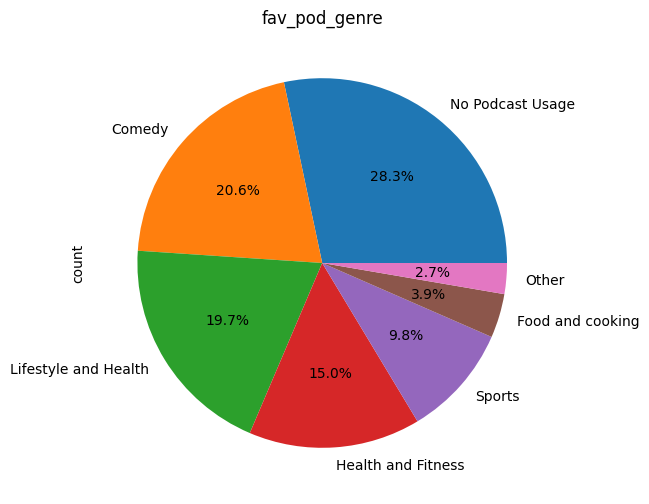

In [20]:
plot_categorical_distribution(df['fav_pod_genre'], chart_type='pie')

### Spotify Listening Device

In [21]:
df['spotify_listening_device'].unique()

array(['Smart speakers or voice assistants', 'Computer or laptop',
       'Smartphone, Smart speakers or voice assistants', 'Smartphone',
       'Smartphone, Computer or laptop',
       'Smartphone, Computer or laptop, Smart speakers or voice assistants',
       'Smartphone, Wearable devices',
       'Smartphone, Computer or laptop, Wearable devices',
       'Computer or laptop, Wearable devices',
       'Smartphone, Computer or laptop, Smart speakers or voice assistants, Wearable devices',
       'Wearable devices',
       'Smartphone, Smart speakers or voice assistants, Wearable devices',
       'Computer or laptop, Smart speakers or voice assistants',
       'Computer or laptop, Smart speakers or voice assistants, Wearable devices',
       'Smart speakers or voice assistants, Wearable devices'],
      dtype=object)

In [22]:
df['spotify_listening_device'].value_counts()


spotify_listening_device
Smartphone                                                                              299
Computer or laptop                                                                       54
Smartphone, Computer or laptop                                                           48
Smart speakers or voice assistants                                                       43
Computer or laptop, Smart speakers or voice assistants                                   14
Smartphone, Smart speakers or voice assistants                                           10
Smartphone, Wearable devices                                                              8
Smartphone, Computer or laptop, Smart speakers or voice assistants, Wearable devices      8
Wearable devices                                                                          8
Smartphone, Computer or laptop, Smart speakers or voice assistants                        7
Computer or laptop, Wearable devices                   

In [23]:
df['uses_smartphone'] = df['spotify_listening_device'].str.contains('Smartphone', case=False).astype(int)
df['uses_computer'] = df['spotify_listening_device'].str.contains('Computer or laptop', case=False).astype(int)
df['uses_speaker'] = df['spotify_listening_device'].str.contains('Smart speakers', case=False).astype(int)
df['uses_wearable'] = df['spotify_listening_device'].str.contains('Wearable devices', case=False).astype(int)


In [24]:
df['device_diversity'] = df[['uses_smartphone','uses_computer','uses_speaker','uses_wearable']].sum(axis=1)


In [25]:
def get_primary_device(x):
    if 'Smartphone' in x:
        return 'Smartphone'
    elif 'Computer or laptop' in x:
        return 'Computer'
    elif 'Smart speakers' in x:
        return 'Speaker'
    elif 'Wearable' in x:
        return 'Wearable'
    else:
        return 'Other'

df['primary_listening_device'] = df['spotify_listening_device'].apply(get_primary_device)


In [26]:
df['device_diversity'].value_counts()

device_diversity
1    404
2     87
3     20
4      8
Name: count, dtype: int64

## What Device Diversity Actually Means

| Device Setup | Likely Lifestyle Pattern | Engagement Interpretation |
|--------------|--------------------------|---------------------------|
| Smartphone only | Casual listener — listens when idle / traveling | Engagement can be low or medium |
| Smartphone + Laptop | Student / working professional using Spotify during work/study | Sustained listening = Higher engagement |
| Smartphone + Laptop + Smart Speaker | Home + commute + desk setup user | Habitual listening → Stable retention |
| Smartphone + Laptop + Wearable + Speaker | Gym + work + home routines | Strong behavioral integration → Very high retention |

So the real insight is:

Engagement is not about having more devices — it's about whether those devices represent different listening contexts (gym, work, home, commute).

Device diversity can correlate with engagement, but not inherently.
What matters is context: if a user listens across multiple environments (e.g., gym, commute, work), Spotify becomes integrated into their daily routine, which strongly predicts retention.
So device diversity is meaningful only when it reflects multi-context listening behavior — not just access to multiple devices.

In [27]:
df.columns = (df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('/', '_')
)


In [28]:
cat_cols = df.select_dtypes(include='object').columns
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)


### Age 

In [29]:
df['age'].unique()


array(['20-35', '12-20', '35-60', '6-12', '60+'], dtype=object)

In [30]:
df['age'].value_counts()


age
20-35    421
12-20     71
35-60     23
6-12       3
60+        1
Name: count, dtype: int64

| Age Group | Count | Notes |
|-----------|-------|-------|
| 20–35 | 421 | The dominant population. This is your core user base. |
| 12–20 | 71 | Younger audience → early-stage brand shaping. |
| 35–60 | 23 | Small but strategically important → potential high-value subscribers. |
| 6–12 | 3 | Almost noise → not analytically meaningful alone. |
| 60+ | 1 | Basically noise. |

In [31]:
def map_age_group(age):
    if age in ['6-12', '12-20']:
        return 'Teen Listener'
    elif age == '20-35':
        return 'Young Adult'
    elif age in ['35-60', '60+']:
        return 'Adult Listener'
df['Age_Segment'] = df['age'].apply(map_age_group)

In [32]:
df['Age_Segment'].value_counts()


Age_Segment
Young Adult       421
Teen Listener      74
Adult Listener     24
Name: count, dtype: int64

### 🎯 Insight: The Young Adult (20–35) Group Has the Highest Premium Subscription Likelihood

### Why?

| Factor | Teen (6–20) | Young Adult (20–35) | Adult (35+) |
|--------|-------------|---------------------|-------------|
| **Financial Independence** | Very low (dependent on parents) | High – earning / early career | High, but spending is allocated toward responsibilities (family, bills) |
| **Usage Intensity** | Moderate (school/study background music) | High – commute, gym, work sessions, social activities | Moderate – usage more situational/relaxation-oriented |
| **Social / Cultural Pressure** | Medium (peer influence) | Very high – shared playlists, group listening, music identity | Low – personalization prioritized over social identity |
| **Feature Sensitivity** (Group sessions, downloadable playlists, recommendations, car mode, gym audio quality) | Likes features but can't pay | Actively seeks premium features | Less likely to switch behavior |

The 20–35 segment has both the economic means and strong social-lifestyle drivers to adopt Premium, making them the primary target for retention and upselling strategies.

#### Hypothesis:
Users aged 20–35 are significantly more likely to convert to premium compared to teens and 35+ adults due to higher usage frequency and lifestyle-driven listening contexts.

### Gender

In [33]:
df['gender'].unique()

array(['Female', 'Male', 'Others'], dtype=object)

In [34]:
df['gender'].value_counts()

gender
Female    390
Male      114
Others     15
Name: count, dtype: int64

In [35]:
pd.crosstab(df['gender'], df['fav_music_genre'], normalize='index') * 100


fav_music_genre,All,"Classical & melody, dance",Electronic/Dance,Kpop,Melody,Old songs,Pop,Rap,Rock,classical,trending songs random
gender,,,,,,,,,,,
Female,0.769231,0.256410,3.076923,1.025641,55.384615,0.000000,15.641026,8.974359,0.000000,14.871795,0.000000
Male,2.631579,0.877193,2.631579,0.000000,35.964912,0.877193,20.175439,12.280702,3.508772,20.175439,0.877193
Others,0.000000,0.000000,6.666667,0.000000,6.666667,0.000000,6.666667,40.000000,0.000000,40.000000,0.000000


### spotify_subscription_plan

In [36]:
df['spotify_subscription_plan'].nunique()

2

In [37]:
df['spotify_subscription_plan'].value_counts()

spotify_subscription_plan
Free (ad-supported)            423
Premium (paid subscription)     96
Name: count, dtype: int64

In [38]:
# standardize label
df['spotify_subscription_plan'] = df['spotify_subscription_plan'].replace({
    'Free (ad-supported)' : 'Free',
    'Premium (paid subscription)': 'Premium'
})

In [39]:
df['spotify_subscription_plan'].value_counts()

spotify_subscription_plan
Free       423
Premium     96
Name: count, dtype: int64

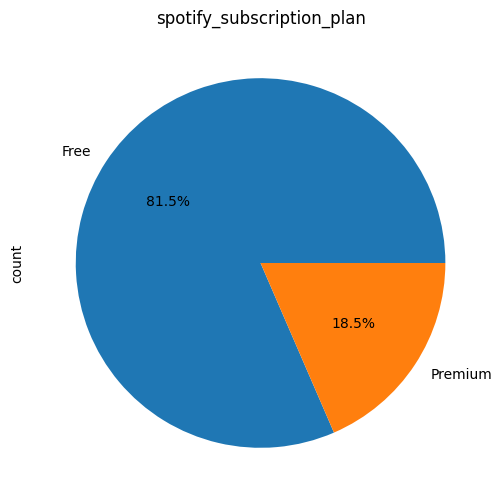

In [40]:
plot_categorical_distribution(df['spotify_subscription_plan'], chart_type='pie')

# Feature Analysis: Spotify Subscription Plan

## Feature: `spotify_subscription_plan`

### Categories:
* Free (ad-supported)
* Premium (paid subscription)

### Observation:
Out of 520 users, 423 (~81%) are on the Free tier, while only 96 (~19%) use Premium.

## Interpretation:

This dataset was collected through a survey, not from platform telemetry, so the Free/Premium distribution reflects user preference and willingness, not Spotify's actual market share. The imbalance here is not a data issue—it's a business signal.

### A high proportion of Free users indicates:
* Cost sensitivity
* Possibly lower perceived value of Premium features
* Potential lack of awareness of Premium benefits

### The Premium users represent:
* High-engagement listeners
* Users who perceive ad-free experience + unlimited skips + higher audio quality as worth paying for

## Business Implication:

The strategic goal is **not** to balance the dataset.

The goal is to **intentionally increase the imbalance in favor of Premium** through conversion efforts.

### To do this effectively, we must:
* Understand why users stay Free
* Identify what drives premium willingness
* Tailor subscription nudges to user listening patterns + engagement level

### preferred_listening_content

In [41]:
df['preferred_listening_content'].unique()

array(['Podcast', 'Music'], dtype=object)

In [42]:
df['preferred_listening_content'].value_counts()

preferred_listening_content
Music      409
Podcast    110
Name: count, dtype: int64

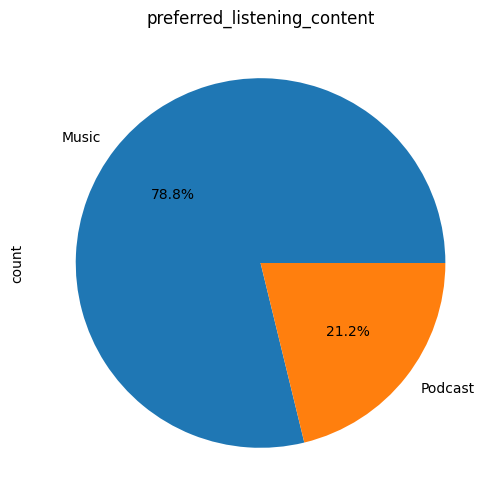

In [43]:
plot_categorical_distribution(df['preferred_listening_content'], chart_type='pie')

# Feature Analysis: Preferred Listening Content

## Feature Meaning

`preferred_listening_content` indicates whether the user primarily uses Spotify for:
* Music
* Podcasts

This variable is important because it reflects core usage behavior, which directly influences:
* Engagement patterns
* Subscription willingness
* Retention vs churn potential

## Distribution

| Category | Percentage | Interpretation |
|----------|------------|----------------|
| Music | ~78.8% | The majority of users are music-first listeners. Likely casual and platform-flexible. |
| Podcast | ~21.2% | Smaller segment, but typically listens for longer continuous sessions. |

## Strategic Interpretation

### 1. Music-first users (~79%)

* Higher chance of jumping across platforms (YouTube Music, Apple Music, Wynk, etc.).
* Behavior tends to be shorter session, more skip frequency.
* Harder to convert to paid subscription because:
  * Ads bother less in short-form content.
  * Music is widely available across platforms for free.

**Business Implication:** To convert this group → you need strong personalization and social experience features (e.g., shared playlists, collaborative sessions, curated vibe playlists).

### 2. Podcast-first users (~21%)

* Podcast listening sessions are long-form, requiring uninterrupted audio.
* Ads are more disruptive → increases likelihood of considering Premium.
* Users are attracted by content depth rather than just convenience.

**Business Implication:** To convert and retain this group → focus on:
* Exclusive or high-quality podcast content
* Personalized recommendations based on genre and host preferences

## Why This Feature Matters for Retention

| Behavior Type | Subscription Likelihood | Retention Value |
|---------------|------------------------|-----------------|
| Music-first (short session) | Lower unless personalized well | Lower loyalty risk |
| Podcast-first (long session) | Higher due to interruption sensitivity | High retention potential |

### fav_music_genre

In [44]:
df['fav_music_genre'].unique()

array(['Melody', 'Rap', 'Pop', 'Classical & melody, dance', 'classical',
       'Rock', 'Old songs', 'Electronic/Dance', 'All', 'Kpop',
       'trending songs random'], dtype=object)

In [45]:
df['fav_music_genre'].value_counts()

fav_music_genre
Melody                       258
classical                     87
Pop                           85
Rap                           55
Electronic/Dance              16
All                            6
Rock                           4
Kpop                           4
Classical & melody, dance      2
Old songs                      1
trending songs random          1
Name: count, dtype: int64

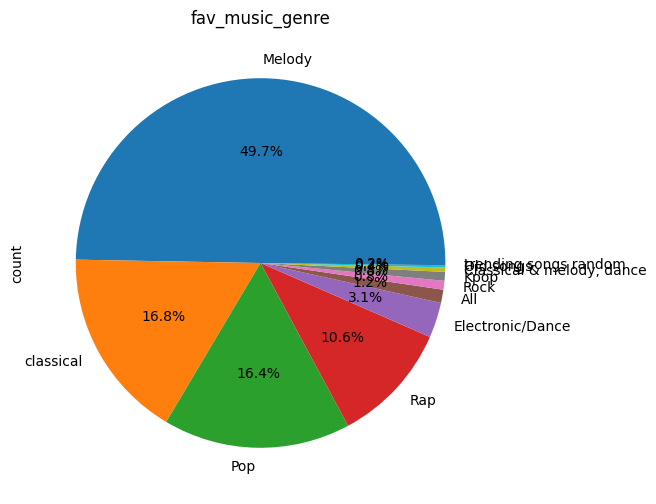

In [46]:
plot_categorical_distribution(df['fav_music_genre'], chart_type='pie')

In [47]:
#standardize text formatting
df['fav_music_genre'] = (
    df['fav_music_genre']
    .str.strip()
    .str.title()
)
df['fav_music_genre'] = df['fav_music_genre'].replace({
    'Classical & Melody, Dance' : 'Classical / Melody'
})
genre_counts = df['fav_music_genre'].value_counts()
print(genre_counts)
rare_threshold = 5
rare_genres = genre_counts[genre_counts < rare_threshold].index
df['fav_music_genre'] = df['fav_music_genre'].replace(rare_genres, 'Other')
df['fav_music_genre'].value_counts()

fav_music_genre
Melody                   258
Classical                 87
Pop                       85
Rap                       55
Electronic/Dance          16
All                        6
Rock                       4
Kpop                       4
Classical / Melody         2
Old Songs                  1
Trending Songs Random      1
Name: count, dtype: int64


fav_music_genre
Melody              258
Classical            87
Pop                  85
Rap                  55
Electronic/Dance     16
Other                12
All                   6
Name: count, dtype: int64

In [48]:
df['fav_music_genre'] = df['fav_music_genre'].replace({'All': 'Other'})
df['fav_music_genre'].value_counts()

fav_music_genre
Melody              258
Classical            87
Pop                  85
Rap                  55
Other                18
Electronic/Dance     16
Name: count, dtype: int64

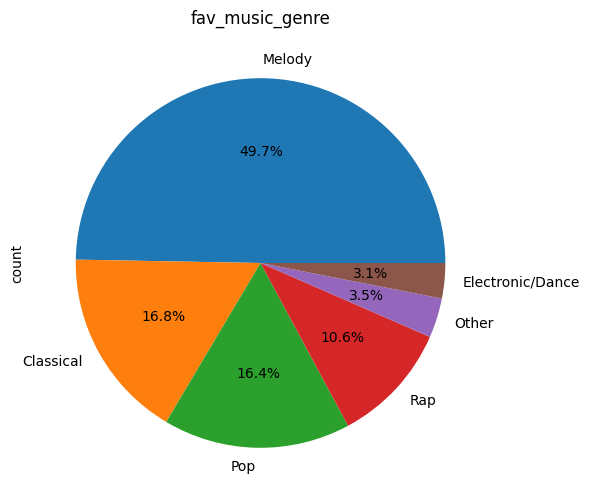

In [49]:
plot_categorical_distribution(df['fav_music_genre'], chart_type='pie')

In [50]:
df['music_time_slot'].unique()

array(['Night', 'Afternoon', 'Morning'], dtype=object)

In [51]:
df['music_time_slot'].value_counts()

music_time_slot
Night        311
Afternoon    117
Morning       91
Name: count, dtype: int64

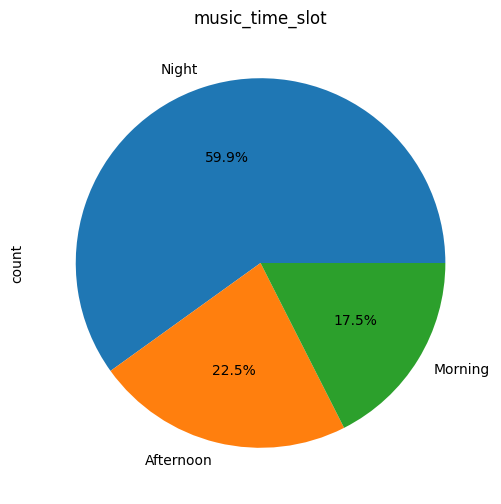

In [52]:
plot_categorical_distribution(df['music_time_slot'], chart_type='pie')

# Why this Feature Is Strategically Important

`music_time_slot` reflects when users habitually engage with Spotify → which is directly tied to retention & habit strength.

**Habit = retention. Retention = revenue.**

Spotify's strongest users are the ones who have routine listening windows.

So now, the correct next move is hypothesis framing — before even visualizing.

## 🧠 Form Hypotheses We Will Test Later

We will form 3 segmentation hypotheses:

| Pair | Why it matters | Expected Behavior (Hypothesis to test later) |
|------|----------------|-----------------------------------------------|
| Gender → Time Slot | Emotional vs. utilitarian listening routines | Females likely dominate Night listening, reflecting reflective/emotional sessions. Males may skew slightly toward Afternoon (workout/travel). |
| Age Group → Time Slot | Daily schedule is age-dependent | 12–20 may show more Night usage; 20–35 likely Night + Afternoon commuting; 35–60 possibly Morning routines. |
| Genre → Time Slot | Mood & energy influence listening timing | Melody & Pop → Night; Rap & Electronic/Dance → Afternoon (activities / workouts). |

# Insight: Music Time Slot

The dataset shows that ~60% of users primarily listen to music at Night, followed by ~22% in the Afternoon and ~17% in the Morning. 
This suggests that Spotify consumption is heavily tied to end-of-day relaxation, emotional winding down, or solitary listening sessions. 
We will test this against demographic (Age, Gender) and preference (fav_music_genre) features to identify strong listener segments. 

Key hypotheses to validate later:
1. Females are more likely to listen at Night due to reflection/emotional music habits.
2. Younger users (12–20) may also skew toward Night listening due to free evenings.
3. Melody/Pop listeners will concentrate in Night sessions, while Rap/Electronic listeners may appear more in Afternoon sessions (workout / activity listening).

















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































### music_influencial_mood

In [53]:
df['music_influencial_mood'].unique()

array(['Sadness or melancholy', 'Social gatherings or parties',
       'Relaxation and stress relief',
       'Relaxation and stress relief, Social gatherings or parties',
       'Uplifting and motivational',
       'Relaxation and stress relief, Uplifting and motivational',
       'Relaxation and stress relief, Uplifting and motivational, Sadness or melancholy, Social gatherings or parties',
       'Relaxation and stress relief, Sadness or melancholy',
       'Relaxation and stress relief, Uplifting and motivational, Social gatherings or parties',
       'Relaxation and stress relief, Uplifting and motivational, Sadness or melancholy',
       'Uplifting and motivational, Sadness or melancholy',
       'Relaxation and stress relief, Sadness or melancholy, Social gatherings or parties',
       'Sadness or melancholy, Social gatherings or parties',
       'Uplifting and motivational, Sadness or melancholy, Social gatherings or parties',
       'Uplifting and motivational, Social gatherin

In [54]:
df['music_influencial_mood'].value_counts()

music_influencial_mood
Relaxation and stress relief                                                                                     194
Uplifting and motivational                                                                                        67
Sadness or melancholy                                                                                             55
Relaxation and stress relief, Uplifting and motivational                                                          44
Relaxation and stress relief, Uplifting and motivational, Sadness or melancholy, Social gatherings or parties     35
Relaxation and stress relief, Sadness or melancholy                                                               33
Relaxation and stress relief, Uplifting and motivational, Sadness or melancholy                                   22
Social gatherings or parties                                                                                      16
Relaxation and stress relief, Uplifting a

In [55]:
mood_columns = {
    'Relaxation': 'Relaxation and stress relief',
    'Motivational': 'Uplifting and motivational',
    'Sadness': 'Sadness or melancholy',
    'Social': 'Social gatherings or parties'
}
for new_col, keyword in mood_columns.items():
    df[new_col] = df['music_influencial_mood'].str.contains(keyword, case=False, na=False).astype(int)

In [56]:
df[['Relaxation', 'Motivational', 'Sadness', 'Social']].sum()

Relaxation      363
Motivational    199
Sadness         167
Social           92
dtype: int64

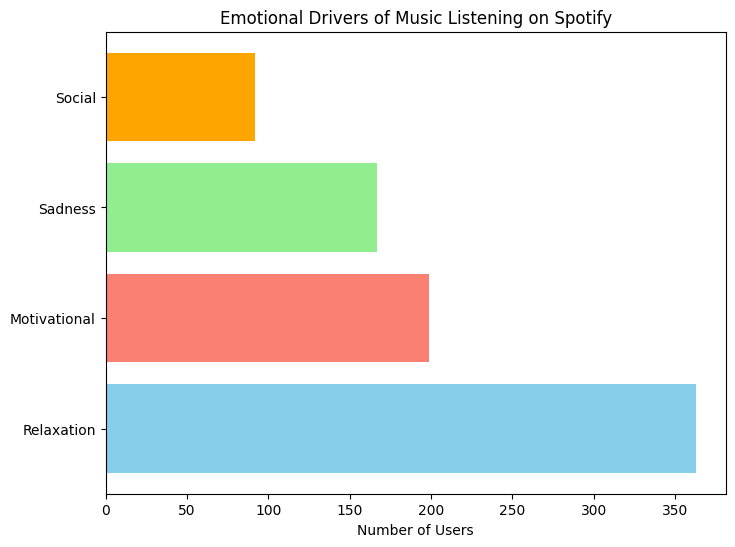

In [57]:
import matplotlib.pyplot as plt
mood_totals = df[['Relaxation', 'Motivational', 'Sadness', 'Social']].sum()
plt.figure(figsize=(8, 6))
plt.barh(mood_totals.index, mood_totals.values, color=['skyblue', 'salmon', 'lightgreen', 'orange'])
plt.xlabel('Number of Users')
plt.title('Emotional Drivers of Music Listening on Spotify')
plt.show()

## Hypothesis

Users who primarily listen to **Relaxation and Sadness** mood-based music are more likely to be loyal and retained because music serves as an **emotional regulation tool** in their daily routine, making Spotify a habitual part of their lifestyle. 

Users who primarily listen to **Motivational and Social (party)** music show weaker retention because their engagement is **context-dependent** (gym, events) rather than daily emotional need.

## ✅ User Personas

| Persona Name | Mood Pattern | Core Motivation | Retention Driver |
|--------------|--------------|-----------------|------------------|
| Comfort Listener | Relaxation music | Uses music to unwind and reduce stress | Habitual emotional calm playlists keep them returning daily |
| Achiever | Motivational music (gym/study focus) | Needs an energy or performance boost | Fresh, high-energy playlist discovery keeps them engaged |
| Heart Listener | Sad or emotional music | Uses music for emotional processing | Feeling understood by personalized mood-based recommendations |
| Social Player | Party / group listening | Music is a social identity / vibe tool | Sharing & collaborative playlists among friend groups keeps them active |

### music_expl_method

In [58]:
df['music_expl_method'].unique()

array(['Playlists', 'recommendations, Playlists', 'Others',
       'recommendations', 'Playlists, Radio', 'recommendations, Others',
       'recommendations, Playlists, Radio', 'recommendations, Radio',
       'recommendations, Playlists, Others', 'Radio', 'Radio, Others',
       'Playlists, Others', 'Playlists, Radio, Others',
       'recommendations, Radio, Others',
       'recommendations,Others, Social media', 'Others, Social media',
       'recommendations, Playlists, Radio, Others', 'Others, Friends',
       'recommendations, Others, Social media', 'Others, Search'],
      dtype=object)

In [59]:
df['music_expl_method'].value_counts()

music_expl_method
Playlists                                    112
recommendations                              112
recommendations, Playlists                    86
Others                                        55
Radio                                         51
Playlists, Radio                              18
recommendations, Playlists, Others            18
recommendations, Others                       15
recommendations, Playlists, Radio             13
Playlists, Others                              9
Radio, Others                                  7
recommendations, Radio                         6
Playlists, Radio, Others                       6
recommendations, Radio, Others                 4
recommendations, Playlists, Radio, Others      2
recommendations,Others, Social media           1
Others, Social media                           1
Others, Friends                                1
recommendations, Others, Social media          1
Others, Search                                 1
Na

In [60]:
df['Uses_Recommendations'] = df['music_expl_method'].str.contains('recommendations', case= False, na=False).astype(int)
df['Uses_Playlists'] = df['music_expl_method'].str.contains('Playlists', case=False, na=False).astype(int)
df['Uses_Radio'] = df['music_expl_method'].str.contains('Radio', case=False, na=False).astype(int)
df['Uses_External'] = df['music_expl_method'].str.contains('Others|Friends|Search|Social media', case=False, na=False).astype(int)


In [61]:
def categorize_method(row):
    if row['Uses_Recommendations'] == 1 and row['Uses_Playlists'] == 1:
        return 'Hybrid: Rec + Playlist'
    elif row['Uses_Recommendations'] == 1:
        return 'Algorithm-driven'
    elif row['Uses_Playlists'] == 1:
        return 'Playlist-driven'
    elif row['Uses_Radio'] == 1:
        return 'Radio/Autoplay'
    elif row['Uses_External'] == 1:
        return 'External Discovery'
    else:
        return 'Unknown'

df['music_expl_category'] = df.apply(categorize_method, axis=1)


In [62]:
df['music_expl_category'].value_counts()

music_expl_category
Playlist-driven           145
Algorithm-driven          139
Hybrid: Rec + Playlist    119
External Discovery         58
Radio/Autoplay             58
Name: count, dtype: int64

| Category | Interpretation | Retention Meaning |
|----------|----------------|-------------------|
| Algorithm-driven | Spotify is main discovery tool | High loyalty |
| Playlist-driven | Identity-based listening | Medium loyalty |
| Hybrid | Strongest engagement | Very high retention |
| Radio/Autoplay | Passive background listening | Low loyalty |
| External Discovery | Spotify is replaceable | High churn risk |

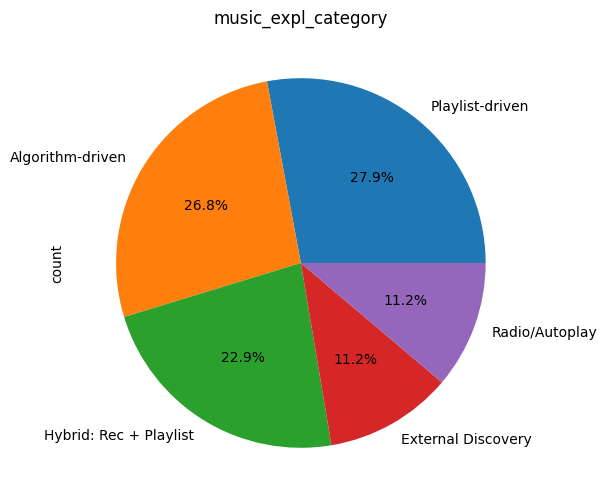

In [63]:
plot_categorical_distribution(df['music_expl_category'], chart_type='pie')

| Category | % of Users | Interpretation | Retention Risk |
|----------|------------|----------------|----------------|
| Playlist-driven | 27.9% | Largest group. Users lean on self-curated listening | Medium retention (identity-driven, but may stagnate if recommendations don't refresh) |
| Algorithm-driven | 26.8% | Almost equal size. Spotify's recommendation system is their main discovery source | High retention (Spotify is part of their listening habit) |
| Hybrid: Rec + Playlist | 22.9% | Very strong segment. They balance curation and algorithmic discovery | Very high retention (deep engagement) |
| External Discovery | 11.2% | Finds music outside Spotify. These users use Spotify only to play music, not discover | High churn risk |
| Radio/Autoplay | 11.2% | Passive listeners. Background listening, low emotional engagement | Medium-to-high churn risk |

## 🎯 Quick Insight Summary 

### 1) Spotify's Recommendation Engine is working

Nearly 50% of users are either:
* Algorithm-driven or
* Hybrid

These users are strongly retained because:
* Their listening journey begins inside Spotify
* Spotify controls their discovery pathway

These are the users who are **cheapest to retain** and **easiest to upsell to Premium**.

### 2) Playlist-driven segment is large but fragile

* This ~28% listens through self-curation
* They don't explore unless nudged

This group needs **personalization refreshers**, otherwise:

They stagnate → boredom → churn → move to YouTube Music/Apple.

### 3) External Discovery & Radio Users = Churn Risk

These users show weak platform loyalty because:
* Spotify is not where they find music
* Spotify is only a player, not a recommendation ecosystem

These are the ones we must target aggressively to prevent churn.

## 💡 Persona Mapping 

| Persona | Category | Behavior | Needs | Risk | Strategy |
|---------|----------|----------|-------|------|----------|
| The Curator | Playlist-driven | Builds & follows playlists | Fresh personalization | Medium | Enhance playlist discovery; "Your Playlist Refresh" feature |
| The Explorer | Algorithm-driven | Depends on recommendations | Diversity & relevance | Low | Strengthen Discover Weekly & personalized mixes |
| The Super-Engaged | Hybrid: Rec + Playlist | Balances personalization & identity | Depth + novelty | Very Low | Offer premium perks (Cross-device sync, lossless audio, lyrics sync) |
| The Casual | Radio / Autoplay | Background listening | Convenience | Medium-High | Promote "Hands-free Premium mode" |
| The Outsider | External Discovery | Discovers music outside Spotify | Clear identity fit | High | Social listening campaigns, influencer-curated playlists |

### music_recc_rating

In [64]:
df['music_recc_rating'].unique()

array([3, 2, 4, 5, 1])

In [65]:
df['music_recc_rating'].value_counts()

music_recc_rating
3    190
4    173
5     86
2     56
1     14
Name: count, dtype: int64

In [66]:
df.groupby('music_expl_category')['music_recc_rating'].mean().sort_values(ascending=False)


music_expl_category
Hybrid: Rec + Playlist    3.941176
Algorithm-driven          3.561151
Playlist-driven           3.462069
External Discovery        3.224138
Radio/Autoplay            2.844828
Name: music_recc_rating, dtype: float64

In [67]:
df.groupby('music_expl_category')['music_recc_rating'].agg(['count','mean']).sort_values(by='mean', ascending=False)


,count,mean
music_expl_category,,
Hybrid: Rec + Playlist,119,3.941176
Algorithm-driven,139,3.561151
Playlist-driven,145,3.462069
External Discovery,58,3.224138
Radio/Autoplay,58,2.844828


## Final Ranked Results (Highest → Lowest Recommendation Satisfaction)

| Exploration Style | Avg Rec Rating | Count | Interpretation |
|-------------------|----------------|-------|----------------|
| Hybrid: Rec + Playlist | 3.94 | 119 | These users trust both algorithm + personal curation. They are the most satisfied and the most retain-able. |
| Algorithm-driven | 3.56 | 139 | Heavy auto-rec consumers. They live/die by recommendation quality. |
| Playlist-driven | 3.46 | 145 | They are consistent listeners, but they rely on themselves, not Spotify. |
| External Discovery | 3.22 | 58 | They don't trust the platform. They come from elsewhere (YouTube, Instagram, friends). |
| Radio / Autoplay | 2.84 | 58 | These are the lowest satisfaction, highest churn-risk users. |

## 🎯 Key Insight 

Users who mix algorithmic recommendations with their own playlists show the highest satisfaction. This suggests that users value personalization, but only when they can refine it themselves.

In simpler terms:
* Pure algorithm? → Feels generic.
* Pure self-curation? → Gets boring / effortful.
* Algorithm + self-curation? → Feels personal, effortless, and relevant.

This is exactly the **psychological sweet spot of retention**.

## 🔥 Business Personas (Now validated with data)

| Persona | Exploration Behavior | Satisfaction | Retention Risk | Strategy |
|---------|---------------------|--------------|----------------|----------|
| The Blended Listener (Hybrid) | Uses playlists + algorithm | Highest | Low | Double down: Mood playlists + weekly personalization drops |
| The Algorithm Believer | Relies on AI picks | High | Medium | Improve rec transparency ("Why this song?") |
| The Self-Curator | Makes + follows playlists | Moderate | Medium | Promote collaborative playlists & playlist badges |
| The External Explorer | Discovers outside Spotify | Low | High | Target with influencer + social music campaigns |
| The Passive Listener (Radio) | Just lets music play | Lowest | Very High | Convert by nudging personalization onboarding |

In [68]:
avg_rating = df.groupby('music_expl_category')['music_recc_rating'].mean().reset_index()

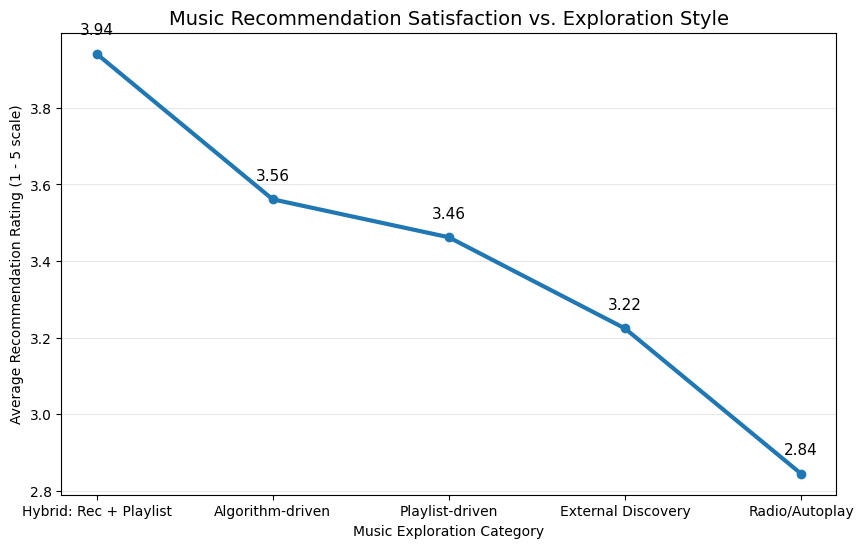

In [69]:
import matplotlib.pyplot as plt

# Sort categories in the meaningful order of personalization → passiveness
order = [
    "Hybrid: Rec + Playlist",
    "Algorithm-driven",
    "Playlist-driven",
    "External Discovery",
    "Radio/Autoplay"
]

avg_rating_sorted = avg_rating.set_index("music_expl_category").loc[order].reset_index()

# Extract values for plotting
categories = avg_rating_sorted["music_expl_category"]
values = avg_rating_sorted["music_recc_rating"]

plt.figure(figsize=(10,6))

# Draw the slope line
plt.plot(categories, values, marker='o', linewidth=3)

# Annotate each point with rating
for i, v in enumerate(values):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', fontsize=11)

# Aesthetics
plt.title("Music Recommendation Satisfaction vs. Exploration Style", fontsize=14)
plt.ylabel("Average Recommendation Rating (1 - 5 scale)")
plt.xlabel("Music Exploration Category")
plt.grid(axis='y', alpha=0.3)

plt.show()

#### Less personalization ---> Lower satisfaction ---> Higher churn risk

### Music_lis_frequency

In [70]:
df['music_lis_frequency'].unique()

array(['leisure time', 'Workout session', 'Study Hours, While Traveling',
       'Office hours, Workout session, leisure time', 'Office hours',
       'While Traveling, leisure time',
       'Office hours, While Traveling, Workout session',
       'Office hours, While Traveling',
       'Office hours, While Traveling, leisure time', 'Social gatherings',
       'While Traveling',
       'While Traveling, Workout session, leisure time', 'Study Hours',
       'Study Hours, leisure time', 'While Traveling, Workout session',
       'Study Hours, Workout session, leisure time',
       'Office hours, While Traveling,', 'Workout session, leisure time',
       'While Traveling, Workout session, leisure time, Night time, when cooking',
       'Office hours, While Traveling, Workout session, leisure time',
       'Study Hours, While Traveling, Workout session, leisure time',
       'Office hours, Study Hours, While Traveling, Workout session, leisure time',
       'Office hours, leisure time', 'S

In [71]:
df['music_lis_frequency'].value_counts()

music_lis_frequency
While Traveling                                                               111
leisure time                                                                   87
While Traveling, leisure time                                                  64
While Traveling, Workout session, leisure time                                 48
Workout session                                                                33
Study Hours                                                                    19
Office hours                                                                   16
While Traveling, Workout session                                               16
Office hours, While Traveling, leisure time                                    12
Office hours, While Traveling                                                  12
Office hours, While Traveling, Workout session                                 10
Study Hours, While Traveling, leisure time                                    

In [72]:
context_map = {
    'Travel_Listening': 'While Traveling',
    'Leisure_Listening': 'leisure time',
    'Workout_Listening': 'Workout session',
    'Study_Listening': 'Study Hours',
    'Office_Listening': 'Office hours',
    'Night_Winddown': 'Before bed'
}

for new_col, phrase in context_map.items():
    df[new_col] = df['music_lis_frequency'].str.contains(phrase, case=False, na=False).astype(int)

df[[*context_map.keys()]].sum()


Travel_Listening     330
Leisure_Listening    262
Workout_Listening    153
Study_Listening       85
Office_Listening      87
Night_Winddown         1
dtype: int64

In [73]:
routine_cols = ['Travel_Listening', 'Leisure_Listening', 'Workout_Listening', 
                'Study_Listening', 'Office_Listening', 'Night_Winddown']

# Group by podcast vs music users
podcast_behavior = df.groupby('preferred_listening_content')[routine_cols].sum()
podcast_behavior


,Travel_Listening,Leisure_Listening,Workout_Listening,Study_Listening,Office_Listening,Night_Winddown
preferred_listening_content,,,,,,
Music,265,239,115,52,75,1
Podcast,65,23,38,33,12,0


| Routine Context | Habit Strength | Retention Potential | Business Interpretation |
|-----------------|----------------|---------------------|-------------------------|
| Travel Listening | High | High | Daily, low-effort listening → users let playback run continuously. These users are more likely to feel inconvenience from ads + device switching → strong candidates for Premium upsell. |
| Workout Listening | Moderate → High | Moderate → High | Music here is tied to motivation and energy. Consistency varies by lifestyle, but when stable, it forms a strong emotional association → curated workout playlists & adaptive tempo recommendations can increase loyalty. |
| Study Listening | Moderate | Moderate | Listening is purposeful but seasonal (exams, semesters). Engagement fluctuates → retention requires providing "focus-mode" playlists and minimal-interruption playback, but churn risk increases during inactivity periods. |

## 🎯 One-Sentence Insight Summary

Podcast engagement is strongest when listening habits occur in stable, repeated daily contexts (especially commuting and workouts), making these contexts the best conversion points for Premium retention strategies.

## ✅ This insight will feed into later:

| Dashboard Section | Use |
|-------------------|-----|
| User Personas | Define "Routine Listener" vs "Session Listener" |
| Retention Strategy Slide | Identify conversion touchpoints |
| Recommendation for Product Team | Improve autoplay + driving mode |

### Spotify_usage_period

In [74]:
df['spotify_usage_period'].unique()

array(['More than 2 years', '6 months to 1 year', '1 year to 2 years',
       'Less than 6 months'], dtype=object)

In [75]:
df['spotify_usage_period'].value_counts()

spotify_usage_period
More than 2 years     169
1 year to 2 years     140
6 months to 1 year    119
Less than 6 months     91
Name: count, dtype: int64

In [76]:
import pandas as pd
usage_order = [
    'Less than 6 months',
    '6 months to 1 year',
    '1 year to 2 years',
    'More than 2 years'
]
df['spotify_usage_period'] = pd.Categorical(
    df['spotify_usage_period'],
    categories=usage_order,
    ordered=True
)

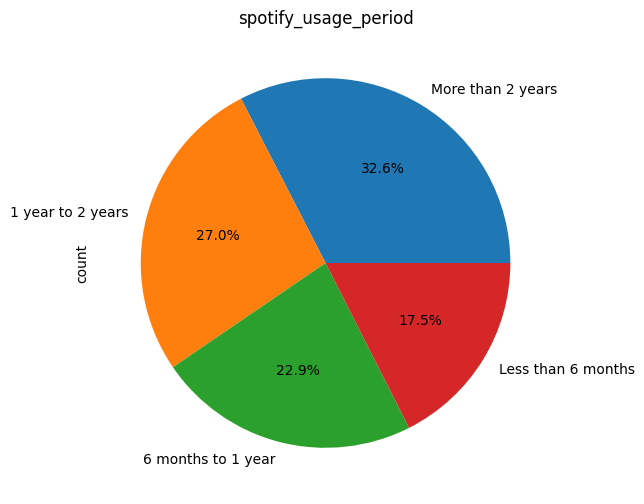

In [77]:
plot_categorical_distribution(df['spotify_usage_period'], chart_type='pie')

# 🧭 Interpretation: Spotify Usage Period Segments

## 1. More than 2 years (32.6%) — The Loyal Core

**Behavior Pattern:** These users have already integrated Spotify into their routine. They rely on the platform for daily listening — commuting, studying, gym, and emotional listening (relaxation/sadness).

**Retention Potential:** ⭐⭐⭐⭐⭐ Very High  
If they haven't churned in 2 years, they are highly sticky.

**Conversion Potential (Free → Premium):** ⭐⭐⭐⭐  
They exhibit the strongest habit loop → the more a habit persists, the more users hate friction (ads, skips).

**Business Strategy:**
* Reward loyalty: "2-year badge", annual plan discount
* Priority for Premium cross-sell
* Personalized mood-based recommendations (relaxation/motivational)

## 2. 1 to 2 years (27%) — Stable Users With Growth Potential

**Behavior Pattern:** Users who have passed the early churn window but not fully loyal yet.

**Retention Potential:** ⭐⭐⭐⭐ Good stability, but still susceptible to switching to a competitor.

**Conversion Potential:** ⭐⭐⭐  
Depends heavily on time-of-day usage and device diversity.

**Business Strategy:**
* Smart personalization nudges (improved recommendations)
* Feature education ("Did you know Premium gives X?")
* First-discount offers (1-month trial → steady conversion)

## 3. 6 months to 1 year (22.9%) — The Developing Habit Users

**Behavior Pattern:** Users still forming their listening habits.

**Retention Potential:** ⭐⭐⭐ Still vulnerable — not fully bonded with Spotify.

**Conversion Potential:** ⭐⭐ Need compelling nudges.

**Business Strategy:**
* Strengthen habit loop:
  * commute playlists
  * study/work mood sets
* Push curated playlists to deepen exploration

This is the critical developmental phase. If not guided → they churn. If guided well → they stay long-term.

## 4. Less than 6 months (17.5%) — High Risk, Early Churn Window

**Behavior Pattern:** Very early users, still exploring. Low emotional connection to the platform.

**Retention Potential:** ⭐⭐ This segment has the highest churn probability.

**Conversion Potential:** ⭐ Don't convert yet — focus on retaining first.

**Business Strategy:**
* Reduce friction (ads should be minimal, less intrusive)
* Promote playlists that match their demographic
* Simplify onboarding + introduce features gradually
* Encourage "Discovery Habit":
  * Weekly Discovery
  * Made for You mixes
  * Easy playlist building

## 📌 Dashboard Summary 

| Usage Period | % Users | Retention Risk | Conversion Potential | Recommended Strategy |
|--------------|---------|----------------|----------------------|----------------------|
| > 2 years | 32.6% | Low | High | Loyalty perks, premium upsell, mood-based content |
| 1–2 years | 27% | Medium–Low | Medium | Personalization nudges, free→premium trials |
| 6–12 months | 22.9% | Medium | Low–Medium | Build habit loops, targeted playlists |
| < 6 months | 17.5% | High | Low | Reduce friction, improve onboarding, enhance discovery |

### pod_lis_frequency

In [78]:
df['pod_lis_frequency'].unique()

array(['Daily', 'Several times a week', 'Once a week', 'Never', 'Rarely'],
      dtype=object)

In [79]:
df['pod_lis_frequency'].value_counts()

pod_lis_frequency
Rarely                  201
Never                   129
Once a week              91
Several times a week     78
Daily                    20
Name: count, dtype: int64

In [80]:
def clean_pod_frequency(x):
    x = x.strip()
    if x == "Never":
        return "Non-podcast user"
    elif x in ["Rarely", "Once a week"]:
        return "Light user"
    elif x in ["Several times a week", "Daily"]:
        return "Regular user"
    else:
        return "Unkown"
df['pod_lis_category'] = df['pod_lis_frequency'].apply(clean_pod_frequency)
df['pod_lis_category'].value_counts()

pod_lis_category
Light user          292
Non-podcast user    129
Regular user         98
Name: count, dtype: int64

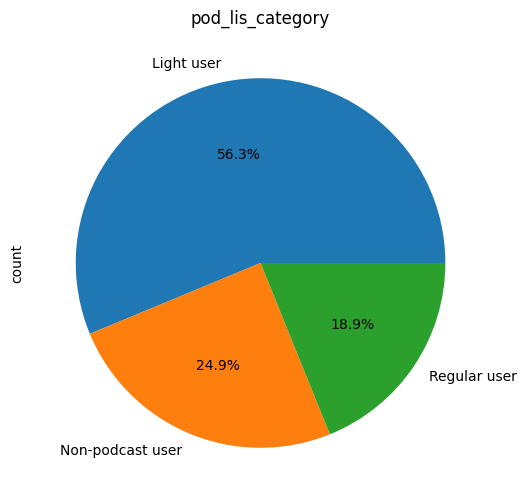

In [81]:
plot_categorical_distribution(df['pod_lis_category'], chart_type='pie')

# ✅ Podcast Listening Frequency — Hypothesis + Personas

## 📌 HYPOTHESIS

Podcast listening frequency reflects habit depth and indicates how easily users can be nudged into premium:

### 1️⃣ "Rarely/Never" (63.5%) → Weak Habit → Lowest retention value

* These users do not have a stable podcast routine.
* They use Spotify primarily for music, so podcast satisfaction does not drive retention.
* They will convert only if:
  * Spotify pushes highly personalized podcast recommendations
  * And these matches are highly relevant.

### 2️⃣ "Once a week / Several times a week" (32.7%) → Growing Habit → High conversion potential

* This segment is the most strategic because:
  * They show interest, but the habit is not fully formed yet.
  * With better recommendations + reduced ad interruptions → they become premium candidates.
* Recommendation quality will strongly influence whether the habit strengthens.

### 3️⃣ "Daily" (3.8%) → Strongest Habit → High retention value

* They treat podcasts like part of a daily routine (commute, work, chores).
* They are least sensitive to platform hopping and most likely to value:
  * Ad-free listening
  * Offline downloads
  * Smart episode queueing
* These users should be kept as "Core Retain" segment.

## 🎭 Podcast Listener Personas

| Persona | Behavior | Retention Driver | Conversion Strategy |
|---------|----------|------------------|---------------------|
| 1. The Casual Dabbler (Rarely/Never) | Barely listens to podcasts; music-first user | Relevance (needs a strong hook) | Push hyper-personalized podcast suggestions tied to music taste |
| 2. The Growing Listener (Weekly) | Slow but consistent podcast adoption | Content match + consistency | Episode bundles, "weekly mix for you", reduce ad interruptions |
| 3. The Routine Listener (Daily) | Podcasts are part of everyday routine | Convenience + seamless experience | Promote premium via offline mode, long-form episodes, no ads |

### pod_variety_satisfaction

In [82]:
df['pod_variety_satisfaction'].unique()

array(['Ok', 'Satisfied', 'Very Satisfied', 'Very Dissatisfied',
       'Dissatisfied'], dtype=object)

In [83]:
df['pod_variety_satisfaction'].value_counts()

pod_variety_satisfaction
Ok                   279
Satisfied            162
Very Satisfied        48
Dissatisfied          20
Very Dissatisfied     10
Name: count, dtype: int64

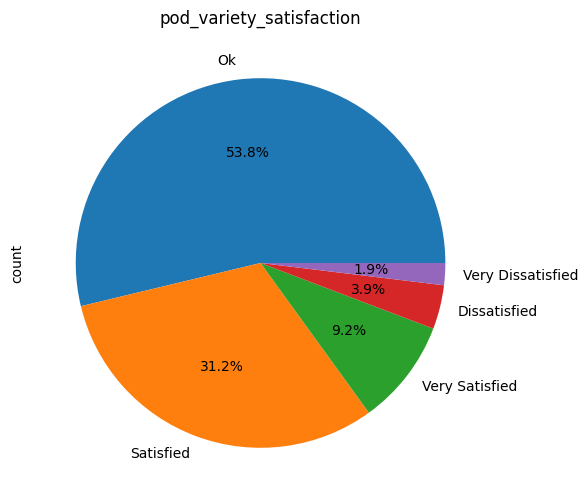

In [84]:
plot_categorical_distribution(df['pod_variety_satisfaction'], chart_type='pie')

## 📌 Podcast Variety Satisfaction — Insights Summary

* The dominant sentiment is neutral: 53.8% rated podcast variety as "Ok". → This audience is not unhappy, but not strongly retained.
* Satisfied (31.2%) and Very Satisfied (9.2%) together form a high-value retention segment. These users are ideal for long-term engagement strategies.
* Dissatisfied (3.9%) and Very Dissatisfied (1.9%) are a small but important churn-risk group, signaling gaps in content relevance and variety.

## 📌 Personas

| Persona | Description | Strategy |
|---------|-------------|----------|
| The "Meh" Listener | Acceptable but indifferent | Needs better discovery tools |
| The Satisfied Explorer | Likes variety | Needs curated and creator-based recommendations |
| The Superfan Listener | Highly loyal | Needs exclusivity and creator-driven engagement |
| The Disappointed Listener | Mildly negative | Needs improved recommendation relevance |
| The Rejector | Actively negative | Focus on music, not forcing podcast exposure |

In [85]:
import os
os.makedirs("../data/cleaned", exist_ok=True)
clean_path = "../data/cleaned/spotify_user_behaviour_cleaned.csv"
df.to_csv(clean_path, index=False)

clean_path

'../data/cleaned/spotify_user_behaviour_cleaned.csv'

In [86]:
df_cleaned = pd.read_csv('C:/Users/adith/spotify_analytics/data/cleaned/spotify_user_behaviour_cleaned.csv')
df.head()

,age,gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,...,Uses_Radio,Uses_External,music_expl_category,Travel_Listening,Leisure_Listening,Workout_Listening,Study_Listening,Office_Listening,Night_Winddown,pod_lis_category
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free,Yes,Family plan,Podcast,Melody,Night,...,0,0,Playlist-driven,0,1,0,0,0,0,Regular user
1,12-20,Male,More than 2 years,Computer or laptop,Free,Yes,Individual plan,Podcast,Rap,Afternoon,...,0,0,Playlist-driven,0,0,1,0,0,0,Regular user
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free,Yes,Student plan,Podcast,Pop,Night,...,0,0,Playlist-driven,1,0,0,1,0,0,Light user
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free,No,None,Music,Melody,Night,...,0,0,Hybrid: Rec + Playlist,0,1,1,0,1,0,Non-podcast user
4,20-35,Female,1 year to 2 years,Smartphone,Free,No,None,Music,Melody,Night,...,0,0,Hybrid: Rec + Playlist,0,1,0,0,0,0,Light user


In [87]:
# 1. Device flags
df['uses_smartphone'] = df['spotify_listening_device'].str.contains('Smartphone', case=False).astype(int)
df['uses_computer'] = df['spotify_listening_device'].str.contains('Computer or laptop', case=False).astype(int)
df['uses_speaker'] = df['spotify_listening_device'].str.contains('Smart speakers', case=False).astype(int)
df['uses_wearable'] = df['spotify_listening_device'].str.contains('Wearable devices', case=False).astype(int)

# 2. Diversity count
df['device_diversity'] = df[['uses_smartphone', 'uses_computer', 'uses_speaker', 'uses_wearable']].sum(axis=1)

# 3. Primary device
def get_primary_device(x):
    if 'Smartphone' in x:
        return 'Smartphone'
    elif 'Computer or laptop' in x:
        return 'Computer'
    elif 'Smart speakers' in x:
        return 'Speaker'
    elif 'Wearable' in x:
        return 'Wearable'
    else:
        return 'Other'

df['primary_listening_device'] = df['spotify_listening_device'].apply(get_primary_device)


In [88]:
df[['uses_smartphone','uses_computer','uses_speaker','uses_wearable','device_diversity','primary_listening_device']].head()


,uses_smartphone,uses_computer,uses_speaker,uses_wearable,device_diversity,primary_listening_device
0,0,0,1,0,1,Speaker
1,0,1,0,0,1,Computer
2,0,0,1,0,1,Speaker
3,1,0,1,0,2,Smartphone
4,1,0,0,0,1,Smartphone


In [89]:
df.head()

,age,gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,...,Uses_Radio,Uses_External,music_expl_category,Travel_Listening,Leisure_Listening,Workout_Listening,Study_Listening,Office_Listening,Night_Winddown,pod_lis_category
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free,Yes,Family plan,Podcast,Melody,Night,...,0,0,Playlist-driven,0,1,0,0,0,0,Regular user
1,12-20,Male,More than 2 years,Computer or laptop,Free,Yes,Individual plan,Podcast,Rap,Afternoon,...,0,0,Playlist-driven,0,0,1,0,0,0,Regular user
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free,Yes,Student plan,Podcast,Pop,Night,...,0,0,Playlist-driven,1,0,0,1,0,0,Light user
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free,No,None,Music,Melody,Night,...,0,0,Hybrid: Rec + Playlist,0,1,1,0,1,0,Non-podcast user
4,20-35,Female,1 year to 2 years,Smartphone,Free,No,None,Music,Melody,Night,...,0,0,Hybrid: Rec + Playlist,0,1,0,0,0,0,Light user


In [93]:
df.to_csv(
    "C:/Users/adith/spotify_analytics/data/cleaned/spotify_user_behavior_cleaned.csv",
    index=False
)
